# Installing Spark for Big Data

In [10]:
# Install spark-related dependencies
!apt-get install openjdk-8-jdk-headless
!wget http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz

!pip install -q findspark
!pip install pyspark

# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u275-b01-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


# Downloading Blackblaze data

## Getting data for 2019 year

In [4]:
%%bash
years=("2019")
quarter=("Q1" "Q2" "Q3" "Q4")
for yr in ${years[@]}
do
  for qt in ${quarter[@]}
  do
    wget https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_"$qt"_"$yr".zip -O data_"$qt"_"$yr".zip;
  done 
done

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Unzip and arrange the downloaded files

In [5]:
%%capture
!unzip /content/data_Q1_2019.zip 
!unzip /content/data_Q2_2019.zip 
!unzip /content/data_Q3_2019.zip 
!unzip /content/data_Q4_2019.zip 

In [6]:
print("Number of csv files in 2019 Q1:", end=" ")
!ls /content/drive_stats_2019_Q1 | wc -l
print("Number of csv files in 2019 Q2:", end=" ")
!ls /content/data_Q2_2019/ | wc -l
print("Number of csv files in 2019 Q3:", end=" ")
!ls /content/data_Q3_2019/ | wc -l
print("Number of csv files in 2019 Q4:", end=" ")
!ls /content/data_Q4_2019/ | wc -l

!mv /content/drive_stats_2019_Q1 /content/data_Q1_2019/

folders = ["/content/data_Q1_2019/","/content/data_Q2_2019/","/content/data_Q3_2019/","/content/data_Q4_2019/"]

Number of csv files in 2019 Q1: 90
Number of csv files in 2019 Q2: 91
Number of csv files in 2019 Q3: 92
Number of csv files in 2019 Q4: 92


# Working on Data

## Loading PySpark and pandas library. <br>
PySpark is used instead of pandas as the number of datapoints is too large (~40M).

In [11]:
# Tools we need to connect to the Spark server, load our data,
# clean it and prepare it
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import isnan, isnull, when, count, col, countDistinct, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType, LongType

import pandas as pd

# Set up constants
APP_NAME = "HDD failures"
SPARK_URL = "local[*]"

sc = pyspark.SparkContext(appName = APP_NAME, master=SPARK_URL)
spark = SparkSession(sc)

## Collecting data from csv

In [12]:
df = spark.read.format("csv").option("header", "true").load('./data_*/*.csv')
%time print(f"Total number of datapoints: {df.count()}")

Total number of datapoints: 40737546
CPU times: user 509 µs, sys: 0 ns, total: 509 µs
Wall time: 460 µs


### Remove useless columns from the dataframe

In [13]:
useful_features = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure']

import re
r = re.compile(".*raw")
newlist = list(filter(r.match, df.columns))

useful_features = useful_features + newlist

df = df[useful_features]

## Seeing modelwise count of HDD for further analysis

In [14]:
%time df.groupBy("model").count().sort("count", ascending=False).show()

+--------------------+--------+
|               model|   count|
+--------------------+--------+
|       ST12000NM0007|12721076|
|         ST4000DM000| 7325582|
|        ST8000NM0055| 5242891|
|HGST HMS5C4040BLE640| 4674986|
|         ST8000DM002| 3591167|
|HGST HUH721212ALN604| 2848164|
|HGST HMS5C4040ALE640| 1048376|
| TOSHIBA MG07ACA14TA|  564829|
|       ST10000NM0086|  437259|
|         ST6000DX000|  379894|
|HGST HUH728080ALE600|  368454|
|HGST HUH721212ALE600|  327080|
|       ST12000NM0008|  321275|
|       ST500LM012 HN|  187707|
|  TOSHIBA MQ01ABF050|  180251|
| TOSHIBA MQ01ABF050M|  139205|
|      WDC WD5000LPVX|   80053|
|          ST500LM030|   79048|
| TOSHIBA MD04ABA400V|   39788|
|        WDC WD60EFRX|   31563|
+--------------------+--------+
only showing top 20 rows

CPU times: user 34 ms, sys: 11.4 ms, total: 45.4 ms
Wall time: 3min 50s


### Taking HDD model with most datapoints

In [15]:
model_df = df.filter(df.model == "ST12000NM0007")
positives_df = df.filter(df.failure == "1")

In [16]:
%%time 
print(f"Total number of datapoints for this model: {model_df.count()}")

Total number of datapoints for this model: 12721076
CPU times: user 26.8 ms, sys: 14 ms, total: 40.7 ms
Wall time: 3min 47s


In [17]:
%%time
print(f"Total positives: {positives_df.count()}")

Total positives: 2263
CPU times: user 31 ms, sys: 8.41 ms, total: 39.4 ms
Wall time: 3min 46s


### See number of Null values in each column 

In [18]:
%time model_df.select([count(when(isnull(c), c)).alias(c) for c in model_df.columns]).show()

+----+-------------+-----+--------------+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|date|serial_number|model|capacity_bytes|failure|smart_1_raw|smart_2_raw|smart_3_raw|smart_4_ra

## Keep only useful coulmns and change their datatypes to intended ones

In [19]:
cols_to_keep = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure']
good_smart = [1,3,4,5,7,9,10,12,187,192,193,194,197,198,199,240,241]
cols_to_keep.extend([f'smart_{num}_raw' for num in good_smart])


# Change datatype to desired one for entire df of same model
model_df = model_df.select(cols_to_keep).dropna()

for c in [f'smart_{num}_raw' for num in good_smart]:
  model_df = model_df.withColumn(c, model_df[c].cast(LongType()))

model_df = model_df.withColumn('capacity_bytes', model_df['capacity_bytes'].cast(LongType()))
model_df = model_df.withColumn('failure', model_df['failure'].cast(IntegerType()))

model_df.printSchema()

# Change datatype to desired one for all the positive ones
positives_df = positives_df.select(cols_to_keep).dropna()

for c in [f'smart_{num}_raw' for num in good_smart]:
  positives_df = positives_df.withColumn(c, positives_df[c].cast(LongType()))

positives_df = positives_df.withColumn('capacity_bytes', positives_df['capacity_bytes'].cast(LongType()))
positives_df = positives_df.withColumn('failure', positives_df['failure'].cast(IntegerType()))

positives_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity_bytes: long (nullable = true)
 |-- failure: integer (nullable = true)
 |-- smart_1_raw: long (nullable = true)
 |-- smart_3_raw: long (nullable = true)
 |-- smart_4_raw: long (nullable = true)
 |-- smart_5_raw: long (nullable = true)
 |-- smart_7_raw: long (nullable = true)
 |-- smart_9_raw: long (nullable = true)
 |-- smart_10_raw: long (nullable = true)
 |-- smart_12_raw: long (nullable = true)
 |-- smart_187_raw: long (nullable = true)
 |-- smart_192_raw: long (nullable = true)
 |-- smart_193_raw: long (nullable = true)
 |-- smart_194_raw: long (nullable = true)
 |-- smart_197_raw: long (nullable = true)
 |-- smart_198_raw: long (nullable = true)
 |-- smart_199_raw: long (nullable = true)
 |-- smart_240_raw: long (nullable = true)
 |-- smart_241_raw: long (nullable = true)

root
 |-- date: string (nullable = true)
 |-- serial_number: string (nullab

### Confirming NaN removal

In [20]:
%time model_df.select([count(when(isnull(c), c)).alias(c) for c in model_df.columns]).show()

+----+-------------+-----+--------------+-------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|date|serial_number|model|capacity_bytes|failure|smart_1_raw|smart_3_raw|smart_4_raw|smart_5_raw|smart_7_raw|smart_9_raw|smart_10_raw|smart_12_raw|smart_187_raw|smart_192_raw|smart_193_raw|smart_194_raw|smart_197_raw|smart_198_raw|smart_199_raw|smart_240_raw|smart_241_raw|
+----+-------------+-----+--------------+-------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   0|            0|    0|             0|      0|          0|          0|          0|          0|          0|          0|           0|           0|            0|            0|   

In [21]:
%%time 
print(f"Total number of datapoints after data cleaning: {model_df.count()}")

Total number of datapoints after data cleaning: 12719454
CPU times: user 30.6 ms, sys: 11.4 ms, total: 42.1 ms
Wall time: 3min 48s


## Sampling data for faster computations 

In [22]:
%%time
new_df = model_df.sample(0.01)
new_df = new_df.union(positives_df).distinct() # Doing union to tackle the problem of class imbalance
new_df_pd = new_df.toPandas() # Converting to pandas as PySpark operations are extremely slow on colab

CPU times: user 1.8 s, sys: 77.8 ms, total: 1.88 s
Wall time: 7min 46s


In [23]:
display(new_df_pd.describe())

,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_12_raw,smart_187_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw
count,1.281560e+05,128156.000000,1.281560e+05,128156.0,128156.000000,128156.000000,1.281560e+05,128156.000000,128156.0,128156.000000,1.281560e+05,128156.000000,128156.000000,1.281560e+05,128156.000000,128156.000000,128156.00000,1.281560e+05,1.281560e+05
mean,1.198919e+13,0.010885,1.228114e+08,0.0,5.687576,79.226599,9.397551e+08,9934.945145,0.0,4.985970,9.675585e+07,983.425216,450.556025,9.001880e+07,0.580855,0.359780,0.13784,3.355398e+10,7.113426e+10
std,2.777126e+11,0.103763,7.042055e+07,0.0,20.193932,1382.114685,1.708436e+10,4774.240569,0.0,5.315554,3.124714e+09,1182.796236,1887.449941,8.114958e+07,32.572395,20.218375,13.90036,2.475180e+10,3.835930e+10
min,5.001079e+11,0.000000,1.024000e+03,0.0,1.000000,0.000000,1.320000e+02,0.000000,0.0,1.000000,0.000000e+00,0.000000,3.000000,1.600000e+01,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00
25%,1.200014e+13,0.000000,6.197024e+07,0.0,2.000000,0.000000,2.021877e+08,6420.000000,0.0,2.000000,0.000000e+00,274.000000,27.000000,3.600000e+01,0.000000,0.000000,0.00000,1.772900e+04,4.580346e+10
50%,1.200014e+13,0.000000,1.235818e+08,0.0,5.000000,0.000000,4.478398e+08,10328.000000,0.0,4.000000,0.000000e+00,641.000000,32.000000,7.884033e+07,0.000000,0.000000,0.00000,4.153601e+10,6.743642e+10
75%,1.200014e+13,0.000000,1.833806e+08,0.0,7.000000,0.000000,7.197137e+08,13561.000000,0.0,7.000000,0.000000e+00,1120.000000,539.000000,1.623121e+08,0.000000,0.000000,0.00000,5.430161e+10,9.782745e+10
max,1.200014e+13,1.000000,2.441396e+08,0.0,5403.000000,64928.000000,2.062573e+12,42189.000000,0.0,517.000000,4.209132e+11,14823.000000,240778.000000,2.441396e+08,5224.000000,3576.000000,3225.00000,2.036700e+11,2.499821e+11


## Scaling the SMART columns and removing useless SMART columns

In [24]:
# Removing smart3 and smart10 because they are all zeros
new_df_pd.drop(columns=['smart_3_raw','smart_10_raw','date','model', 'serial_number','capacity_bytes'], axis=1, inplace=True)

good_smart = [1,4,5,7,9,12,187,192,193,194,197,198,199,240,241]
cols_to_norm =  [f'smart_{num}_raw' for num in good_smart]

# Scale min max to 0-1 for better predictions
new_df_pd[cols_to_norm] = new_df_pd[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
new_df_pd.sample(n=5)

,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw
24399,0,0.327639,0.000000,0.0,0.000043,0.196283,0.000000,0.0,0.007758,0.002106,6.553627e-08,0.0,0.0,0.0,4.013847e-08,0.171445
3465,0,0.402277,0.000000,0.0,0.000120,0.225367,0.000000,0.0,0.031977,0.000120,4.022796e-01,0.0,0.0,0.0,2.515002e-01,0.340447
96689,0,0.844221,0.000926,0.0,0.000122,0.446443,0.005814,0.0,0.017068,0.013365,6.144026e-08,0.0,0.0,0.0,8.623265e-08,0.264431
12060,0,0.709418,0.000185,0.0,0.000132,0.230913,0.000000,0.0,0.038993,0.000096,7.094193e-01,0.0,0.0,0.0,2.519928e-01,0.191898
68437,0,0.505774,0.001481,0.0,0.000147,0.399891,0.013566,0.0,0.015719,0.003343,3.276814e-08,0.0,0.0,0.0,8.232436e-08,0.286936


### Final processed pandas dataframe

In [25]:
display(new_df_pd.describe())

,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw
count,128156.000000,128156.000000,128156.000000,128156.000000,128156.000000,128156.000000,128156.000000,128156.000000,128156.000000,128156.000000,1.281560e+05,128156.000000,128156.000000,128156.000000,1.281560e+05,128156.000000
mean,0.010885,0.503036,0.000868,0.001220,0.000456,0.235487,0.007725,0.000230,0.066345,0.001859,3.687185e-01,0.000111,0.000101,0.000043,1.647468e-01,0.284557
std,0.103763,0.288445,0.003738,0.021287,0.008283,0.113163,0.010301,0.007424,0.079795,0.007839,3.323901e-01,0.006235,0.005654,0.004310,1.215289e-01,0.153448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.253828,0.000185,0.000000,0.000098,0.152172,0.001938,0.000000,0.018485,0.000100,8.192034e-08,0.000000,0.000000,0.000000,8.704769e-08,0.183227
50%,0.000000,0.506191,0.000740,0.000000,0.000217,0.244803,0.005814,0.000000,0.043244,0.000120,3.229313e-01,0.000000,0.000000,0.000000,2.039378e-01,0.269765
75%,0.000000,0.751129,0.001111,0.000000,0.000349,0.321434,0.011628,0.000000,0.075558,0.002226,6.648330e-01,0.000000,0.000000,0.000000,2.666157e-01,0.391338
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000


# Applying XGBoost for classification

## Importing XGB modules and making train, test dataframes for training and testing

In [26]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import pickle

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_absolute_error,accuracy_score, classification_report


X = new_df_pd.drop(['failure'], axis=1).values
y = new_df_pd['failure'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Train and test dataset shapes

In [27]:
print(x_train.shape)
print(x_test.shape)

(89709, 15)
(38447, 15)


## Train and save XGB model

In [28]:
eval_set = [(x_test,y_test)]
clf = XGBClassifier(objective ='reg:linear', 
                             max_depth = 3,
                             silent = 1,
                             learning_rate = 0.3,
                             n_estimators = 200)

clf.fit(x_train, y_train, early_stopping_rounds=10,eval_metric= 'logloss', eval_set=eval_set)
pickle.dump(clf, open("xgb.pickle.dat", "wb"))

[0]	validation_0-logloss:0.437961
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.292563
[2]	validation_0-logloss:0.202546
[3]	validation_0-logloss:0.144566
[4]	validation_0-logloss:0.106159
[5]	validation_0-logloss:0.080386
[6]	validation_0-logloss:0.062939
[7]	validation_0-logloss:0.050965
[8]	validation_0-logloss:0.042938
[9]	validation_0-logloss:0.03754
[10]	validation_0-logloss:0.033863
[11]	validation_0-logloss:0.031174
[12]	validation_0-logloss:0.029551
[13]	validation_0-logloss:0.028476
[14]	validation_0-logloss:0.027712
[15]	validation_0-logloss:0.027162
[16]	validation_0-logloss:0.026889
[17]	validation_0-logloss:0.026722
[18]	validation_0-logloss:0.026608
[19]	validation_0-logloss:0.026518
[20]	validation_0-logloss:0.026403
[21]	validation_0-logloss:0.026409
[22]	validation_0-logloss:0.02636
[23]	validation_0-logloss:0.026326
[24]	validation_0-logloss:0.02632
[25]	validation_0-logloss:0.026296
[26]	validation_0-logloss:0.026336


## Importing XGB model and performing predictions on testing data

In [29]:
clf = pickle.load(open("xgb.pickle.dat", "rb"))
y_pred = clf.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy",accuracy)

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     38051
           1       0.71      0.40      0.51       396

    accuracy                           0.99     38447
   macro avg       0.85      0.70      0.76     38447
weighted avg       0.99      0.99      0.99     38447

Confusion Matrix: 
 [[37985    66]
 [  236   160]]

Accuracy 0.9921450308216506


### Plotting feature importance. We can observe that SMART5 has largest correlation with failure of HDD

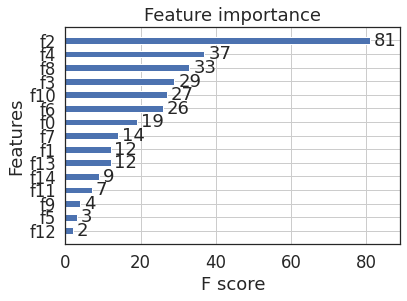

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.5)
sns.set_style('white')

plot_importance(clf,height=0.5)
plt.show()

# Applying Neural Network for classification

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.layers.core import Flatten
from keras.callbacks import EarlyStopping
from keras.models import load_model, save_model
import keras
import numpy as np

## Making model and deciding metrics for evaluation

In [32]:
METRICS = [ 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(32, input_dim=15, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(8, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Finding initial bias to tackle class imbalance

In [33]:
#Find Bias
new_df_pd['failure'].value_counts()

0    126761
1      1395
Name: failure, dtype: int64

In [34]:
neg = 126724
pos = 1395
initial_bias = np.log([pos/neg])

## Making the model

In [35]:
model = make_model(output_bias=initial_bias)

early_stopping = EarlyStopping(
    monitor='val_recall', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

print(model.summary())
print(x_train.shape[1])
print(y_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
______________________________________________________

## Making validation set and training the model

In [37]:
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2)

training_history = model.fit(x_trn, y_trn, validation_data=(x_val, y_val), epochs=500, batch_size=256, callbacks=[early_stopping])
save_model(model, 'keras_model.h5')

Epoch 1/500
281/281 [==============================] - 1s 5ms/step - loss: 0.0607 - accuracy: 0.9887 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5764 - val_loss: 0.0560 - val_accuracy: 0.9894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7005
Epoch 2/500
281/281 [==============================] - 1s 3ms/step - loss: 0.0553 - accuracy: 0.9889 - precision: 0.7241 - recall: 0.0260 - auc: 0.6960 - val_loss: 0.0498 - val_accuracy: 0.9894 - val_precision: 0.5000 - val_recall: 0.0263 - val_auc: 0.7006
Epoch 3/500
281/281 [==============================] - 1s 3ms/step - loss: 0.0498 - accuracy: 0.9900 - precision: 0.8450 - recall: 0.1347 - auc: 0.7359 - val_loss: 0.0472 - val_accuracy: 0.9899 - val_precision: 0.6538 - val_recall: 0.0895 - val_auc: 0.7287
Epoch 4/500
281/281 [==============================] - 1s 3ms/step - loss: 0.0489 - accuracy: 0.9901 - precision: 0.7941 - recall: 0.1669 - auc: 0.7587 - val_loss: 0.0454 - val_accuracy: 0.9906 - val_precision: 0.

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


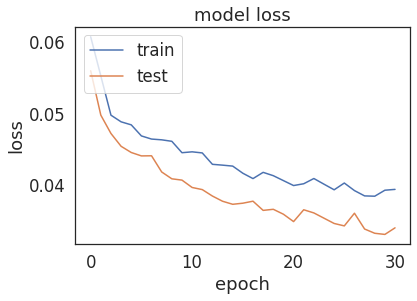

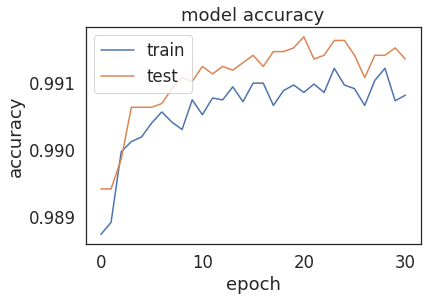

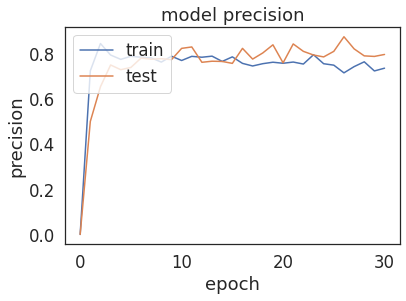

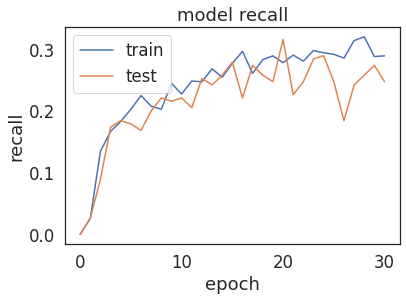

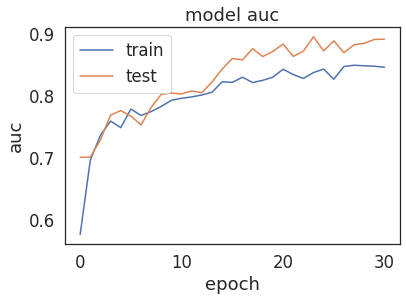

In [57]:
# list all data in history
print(training_history.history.keys())
keys = ['loss', 'accuracy', 'precision', 'recall', 'auc']

for key in keys:
  # summarize history for key
  plt.plot(training_history.history[key])
  plt.plot(training_history.history[f'val_{key}'])
  plt.title(f'model {key}')
  plt.ylabel(key)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Loading saved model and performing evaluation

In [38]:
model = load_model('keras_model.h5')
results = model.evaluate(x_test, y_test, verbose=1)

1202/1202 [==============================] - 2s 1ms/step - loss: 0.0328 - accuracy: 0.9927 - precision: 0.8671 - recall: 0.3460 - auc: 0.8598


In [39]:
print(f'Test accuracy: {results[1]*100}%, Test precision: {results[2]}, Test recall: {results[3]}, Test AUC: {results[4]}')

Test accuracy: 99.27172660827637%, Test precision: 0.8670886158943176, Test recall: 0.3459596037864685, Test AUC: 0.8598048686981201


### Making predictions with saved model

In [40]:
y_pred = model.predict_classes(x_test)
target_names= ['Class 1(FAIL)', 'Class 0(NOT FAIL)']
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,target_names=target_names))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion Matrix: 
 [[38030    21]
 [  259   137]]
                   precision    recall  f1-score   support

    Class 1(FAIL)       0.99      1.00      1.00     38051
Class 0(NOT FAIL)       0.87      0.35      0.49       396

         accuracy                           0.99     38447
        macro avg       0.93      0.67      0.75     38447
     weighted avg       0.99      0.99      0.99     38447



# Demonstrative use of the models

## Download the models trained above
Incase you wish **not** to train them again

### Download XGB_model

In [41]:
%%bash
wget https://bighome.iitb.ac.in/index.php/s/4iERSrpcp6iRAJn/download -O xgb.pickle.dat

--2020-12-17 16:46:46--  https://bighome.iitb.ac.in/index.php/s/4iERSrpcp6iRAJn/download
Resolving bighome.iitb.ac.in (bighome.iitb.ac.in)... 103.21.126.131
Connecting to bighome.iitb.ac.in (bighome.iitb.ac.in)|103.21.126.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34801 (34K) [application/octet-stream]
Saving to: ‘xgb.pickle.dat’

     0K .......... .......... .......... ...                  100%  131K=0.3s

2020-12-17 16:46:48 (131 KB/s) - ‘xgb.pickle.dat’ saved [34801/34801]



### Download Keras model

In [42]:
%%bash
wget https://bighome.iitb.ac.in/index.php/s/YwspfCWcNnRETAg/download -O keras_model.h5

--2020-12-17 16:46:51--  https://bighome.iitb.ac.in/index.php/s/YwspfCWcNnRETAg/download
Resolving bighome.iitb.ac.in (bighome.iitb.ac.in)... 103.21.126.131
Connecting to bighome.iitb.ac.in (bighome.iitb.ac.in)|103.21.126.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57832 (56K) [application/octet-stream]
Saving to: ‘keras_model.h5’

     0K .......... .......... .......... .......... .......... 88% 99.1K 0s
    50K ......                                                100%  151M=0.5s

2020-12-17 16:46:53 (112 KB/s) - ‘keras_model.h5’ saved [57832/57832]



## Sample Test data in np array format
Download for testing the below demo code

In [60]:
!wget https://bighome.iitb.ac.in/index.php/s/RB8spWCpzqoYiET/download -O x_test.npy
x_test = np.load('./x_test.npy')

--2020-12-17 16:58:50--  https://bighome.iitb.ac.in/index.php/s/RB8spWCpzqoYiET/download
Resolving bighome.iitb.ac.in (bighome.iitb.ac.in)... 103.21.126.131
Connecting to bighome.iitb.ac.in (bighome.iitb.ac.in)|103.21.126.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4613768 (4.4M) [application/octet-stream]
Saving to: ‘x_test.npy’

x_test.npy          100%[===================>]   4.40M  2.17MB/s    in 2.0s    

2020-12-17 16:58:53 (2.17 MB/s) - ‘x_test.npy’ saved [4613768/4613768]



## Function to use models trained above

In [53]:
import pickle
from keras.models import load_model

def predict_HDD_failure(load_file, x_test, model='XGBoost'):
  """
  Returns the predicted status of the hard disk drive

  inputs:
    model -- ['XGBoost', 'NN'] (default: 'XGBoost')
    load_file -- path to the model file on the disk. 
    x_test -- path to the numpy array of the data to predict on. Dataframe 
    should have the following columns: []

  """

  if model=='XGBoost':
    clf = pickle.load(open(load_file, "rb"))
    y_pred = clf.predict(x_test)

  elif model=='NN':
    model = load_model(load_file)
    y_pred = model.predict_classes(x_test).squeeze()

  else:
    raise NameError('This type of model is not supported yet!') 

  return y_pred

## Use function to get predictions

In [51]:
# XGB Demo
prediction_array = predict_HDD_failure('./xgb.pickle.dat', x_test)
print(prediction_array)

[16:50:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0 0 0 ... 0 0 0]


In [61]:
# NN Demo
prediction_array = predict_HDD_failure('./keras_model.h5', x_test, model='NN')
print(prediction_array)

[0 0 0 ... 0 0 0]
